# Analyses of the SSCx Dissemination Circuits.

We develop analyses to validate the SSCx dissemination circuits using DMT. 
In addition to a release report, this notebook will also serve as an introduction
to the capabilities of DMT.

## Introduction to DMT.

We start by discussing how to put together an analysis of the pathway 
connection probability using DMT. 
In addition to statistics, a circuit analysis should provide documentation 
as a report.
This report should include the phenomenon analyzed,
the computational methods used to measure the phenomenon, 
and a statistical summary of the analysis. 
If the analysis validates the circuit against experimental data, 
the statistical summary should provide information for the reference
data.


With reporting as a primary goal, we have provided tools within DMT 
to document the analysis code itself to auto-generate reports. The analyst
can provide the documentation in the context of independent components.

### Phenomenon
Each of our structured analyses studies a single circuit phenomenon.
We provide a `class Phenomenon` to describe a circuit phenomenon:


In [1]:
from dmt.tk.phenomenon import Phenomenon

connection_probability_phenomenon = Phenomenon(
    "Connection Probability",
    """
    Probability that two neurons in a pathway are connected.
    While most of the interest will be in `mtype-->mtype` pathways,
    we can define a pathway as a any two group of cells, one on 
    the afferent side, the other on the efferent side of a (possible)
    synapse. Given the pre-synaptic and post-synaptic cell types (groups),
    connection probability counts the fraction of connected pre-synaptic,
    post-synaptic pairs. Connection probability may be calculated as a 
    function of the soma-distance between the cells in a pair, in which
    case the measured quantity will be vector-valued data such as a 
    `pandas.Series`.
    """)

### Interface

To make our analyses work with different circuits, we will define an interface,
that an adapter for the circuit model must implement:

In [2]:
from dmt.model.interface import Interface

class ConnectionProbabilityInterface(Interface):
    """
    Document the methods that must be adapted for a circuit model to
    use for analyzing pathway connection probability.
    """
    __measurement__ = "connection_probability"
    def get_label(self, circuit_model):
        """
        A label that can be used to name a pandas.DataFrame column, 
        and caption figures.
        
        Arguments
        -----------
        circuit_model : The circuit model that will be analyzed
        """
        raise NotImplementedError
        
    def get_mtypes(self, circuit_model):
        """
        A 1D numpy array providing the `mtype`s in the circuit model.
        
        Arguments
        -----------
        circuit_model : The circuit model that will be analyzed
        """
        raise NotImplementedError
        
    def get_pathways(self,
            circuit_model=None,
            cell_group=None):
        """
        Arguments
        ---------------
        cell_group : An object that specifies cell groups.
        ~   This may be 
        ~   1. Either a frozen-set of strings that represent cell properties.
        ~   2. Or, a mapping from cell properties to their values.

        Returns
        ------------
        pandas.DataFrame with nested columns, with two columns 
        `(pre_synaptic, post_synaptic)` at the 0-th level.
        Under each of these two columns should be one column each for
        the cell properties specified in the `cell_group` when it is a
        set, or its keys if it is a mapping.
        ~   1. When `cell_group` is a set of cell properties, pathways between
        ~      all possible values of these cell properties.
        ~   2. When `cell-group` is a mapping, pathways between cell groups
        ~      that satisfy the mapping values.
        """
        raise NotImplementedError
        
    def get_connection_probability(self,
            circuit_model,
            pre_synaptic_cell_type,
            post_synaptic_cell_type):
        """
        Get connection probability of a pathway.

        Arguments
        --------------
        pre/(post)_synaptic_cell_type: A mapping of cell property to its value.
        ~                              The two mappings defines the cell type 
        ~                              on the afferent, and efferent sides of
        ~                              a synapse.
        Returns
        --------------
        A float value for the connection probability, i.e. number of 
        connected pairs divided by the total number of pairs sampled.
        """
        raise NotImplementedError



### Adapter

To analyze a given circuit model we will need to adapt it to the interface
used by the analysis code. 
We have defined `class BlueBrainCircuitAdapter` that adapts several of 
our analyses.

In [3]:
from neuro_dmt.models.bluebrain.circuit.adapter import\
    BlueBrainCircuitAdapter

adapter = BlueBrainCircuitAdapter()

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')


### Measurement Parameters

To determine parameters to be used for measuring a phenomenon on a circuit,
we use `class Parameters`.
We will extract these parameters from our circuit using an instance
of `BlueBrainCircuitAdapter`.
In addition to `BlueBrainCircuitAdapter`, we have defined a wrapper around 
BluePy circuits to account for differences in various circuit models developed
at the BlueBrainProject. Together with `class BlueBrainCircuitModel`, 
`class BlueBrainCircuitAdapter` allows is to apply the same analysis code 
to several circuits developed at the BlueBrainProject.

As an example, we will use a mock circuit that behaves like any other 
circuit developed at BlueBrainProject.

In [5]:
from dmt.tk.parameters import\
    Parameters
from neuro_dmt.models.bluebrain.circuit.model import\
    BlueBrainCircuitModel
from neuro_dmt.models.bluebrain.circuit.mock.circuit import\
    MockCircuit
from neuro_dmt.models.bluebrain.circuit.mock.test.mock_circuit_light import\
    circuit_composition,\
    circuit_connectivity

bluepy_mock_circuit =\
    MockCircuit.build(
        circuit_composition,
        circuit_connectivity)
mock_circuit_model =\
    BlueBrainCircuitModel(
        bluepy_mock_circuit,
        label="BlueBrainCircuitModelMockLight")

pathways_all = adapter.get_pathways(
    mock_circuit_model,
    cell_group={"mtype",})

The pathways obtained from the circuit model are a `pandas.DataFrame` with
two columns:

In [6]:
pathways_all.head()

,pre_synaptic,post_synaptic
,mtype,mtype
0,L1_DAC,L1_DAC
1,L1_DAC,L1_SLAC
2,L1_DAC,L23_MC
3,L1_DAC,L23_ChC
4,L1_DAC,L23_SBC


The number of pathways collected contain all possible
`pre_synaptic_mtype-->post_synaptic_mtype`
pairs:

In [7]:
mtypes = mock_circuit_model.mtypes
assert isinstance(mtypes, np.ndarray)
assert pathways_all.shape[0] == len(mtypes) * len(mtypes)
mtypes

array(['L1_DAC', 'L1_SLAC', 'L23_MC', 'L23_ChC', 'L23_SBC', 'L4_LBC',
       'L4_NGC', 'L4_TPC', 'L5_DBC', 'L5_MC', 'L5_TPC:A', 'L5_TPC:B',
       'L5_UPC', 'L6_ChC', 'L6_IPC', 'L6_MC', 'L6_TPC:A', 'L6_TPC:B',
       'L6_UPC'], dtype=object)

We may be interested not in all pathways, but a selection.
We can obtain these pathways by passing the desired cell types:

In [8]:
import pandas as pd
from collections import OrderedDict
cell_types=pd.DataFrame([
    OrderedDict({"mtype": "L23_MC"}),
    OrderedDict({"mtype": "L6_TPC:A"}), 
    OrderedDict({"mtype": "L5_TPC:A"}),
    OrderedDict({"mtype": "L5_MC"}),
    OrderedDict({"mtype": "L6_ChC"})])
cell_types

,mtype
0,L23_MC
1,L6_TPC:A
2,L5_TPC:A
3,L5_MC
4,L6_ChC


In [9]:
pathways_select =\
    adapter.get_pathways(
        mock_circuit_model,
        cell_group=cell_types)
assert pathways_select.shape[0] == cell_types.shape[0] * cell_types.shape[0]
for cell_type in cell_types.mtype:
    assert cell_type in pathways_select.pre_synaptic.mtype.values
    assert cell_type in pathways_select.post_synaptic.mtype.values
    
pathways_select.head()

,pre_synaptic,post_synaptic
,mtype,mtype
0,L23_MC,L23_MC
1,L23_MC,L6_TPC:A
2,L23_MC,L5_TPC:A
3,L23_MC,L5_MC
4,L23_MC,L6_ChC


We can now define the parameters over which we will make a measurement:

In [10]:
pathway_parameters = Parameters(pathways_select)
pd.testing.assert_frame_equal(
    pathway_parameters.values,
    pathways_select)

### Plotter
    
Our analyses will plot figures. We provide several standardized plotters that 
take measurement data and produce a figure. 
For pathway properties, the heatmap is a common plotter.

In [11]:
from dmt.tk.plotting.heatmap import HeatMap

heatmap_plotter = HeatMap(
    xvar=("pre_synaptic", "mtype"),
    xlabel="pre-synaptic mtype",
    yvar=("post_synaptic", "mtype"),
    ylabel="post-synaptic mtype",
    vvar=("connection_probability", "mean"))

### Analysis

Using the components defined above, we can now compose an analysis

In [12]:
from neuro_dmt.analysis.circuit import BrainCircuitAnalysis

connection_probability_analysis =\
    BrainCircuitAnalysis(
        phenomenon=connection_probability_phenomenon,
        AdapterInterface=ConnectionProbabilityInterface,
        measurement_parameters=Parameters(pathways_select),
        plotter=heatmap_plotter)

In [17]:
connection_probability_measurement =\
    connection_probability_analysis.get_measurement(
        mock_circuit_model,
        adapter,
        sample_size=20)

In [20]:
connection_probability_measurement.head()

connection_probability
dataset                        (pre_synaptic, mtype) (post_synaptic, mtype)                        
BlueBrainCircuitModelMockLight L23_MC                L23_MC                                  0.0172
                                                     L23_MC                                  0.0184
                                                     L23_MC                                  0.0197
                                                     L23_MC                                  0.0189
                                                     L23_MC                                  0.0182

We can obtain a heatmap:

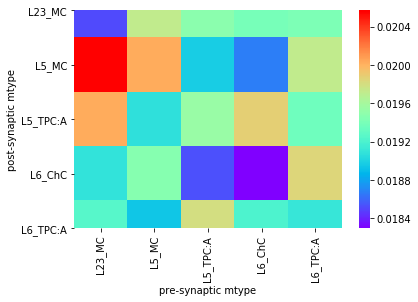

In [22]:
heatmap_plotter.get_figure(connection_probability_measurement)

A `BrainCircuitAnalysis` can produce a report:

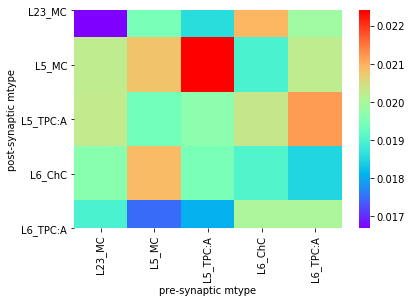

In [26]:
connection_probability_analysis_report =\
    connection_probability_analysis(
        mock_circuit_model,
        adapter,
        sample_size=2)

The report generated by the analysis can be saved using a reporter. 
We have defined `class Reporter` that can be used for posting the report.

In [29]:
from dmt.tk.reporting import Reporter

reporter =\
    Reporter(
        path_output_folder="analyses")
path_report =\
    reporter.post(connection_probability_analysis_report)
print(
    """
    A report for the analysis of circuit connection probability has been 
    saved at: {}
    """.format(path_report))


    A report for the analysis of circuit connection probability has been 
    saved at: analyses/connection_probability
    


In [34]:
import os
os.listdir(path_report)
for root, dirs, files in os.walk(path_report):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))
    for file in files:
        print(len(path) * '---', file)

--- connection_probability
------ report.txt
------ connection_probability.csv
------ figures
--------- connection_probability_by_pre_synaptic_mtype_post_synaptic_mtype.png


If we provide a reporter to the analysis, the analysis instance will save the
report:

'analyses/connection_probability'

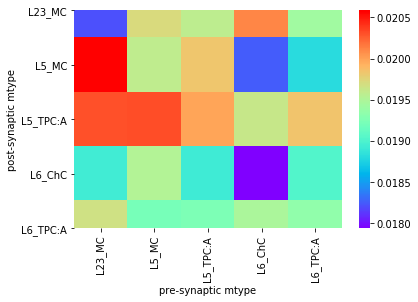

In [36]:
connection_probability_analysis =\
    BrainCircuitAnalysis(
        phenomenon=connection_probability_phenomenon,
        AdapterInterface=ConnectionProbabilityInterface,
        measurement_parameters=Parameters(pathways_select),
        plotter=heatmap_plotter,
        reporter=reporter)
connection_probability_analysis(
    mock_circuit_model,
    adapter)

In rest of the notebook, we develop several analyses of the circuit connectome on the lines
discussed above.

## Connection Probability

We have already defined a basic connection probability analysis.
However connection probability over all cells in the circuit does not give an accurate 
picture since the probability that two cells are connected should depend on the distance
between their somas. So we should measure connection probability as a function of
*soma-distance* between cell pairs in a pathway. We require that the circuit model
adapter provides a method to make such a measurement:

In [13]:
class ConnectionProbabilityInterface(Interface):
    """
    Document the methods that must be adapted for a circuit model to
    use for analyzing pathway connection probability.
    """
    __measurement__ = "connection_probability"
    def get_label(self, circuit_model):
        """
        A label that can be used to name a pandas.DataFrame column, 
        and caption figures.
        
        Arguments
        -----------
        circuit_model : The circuit model that will be analyzed
        """
        raise NotImplementedError
        
    def get_mtypes(self, circuit_model):
        """
        A 1D numpy array providing the `mtype`s in the circuit model.
        
        Arguments
        -----------
        circuit_model : The circuit model that will be analyzed
        """
        raise NotImplementedError
        
    def get_pathways(self,
            circuit_model=None,
            cell_group=None):
        """
        Arguments
        ---------------
        cell_group : An object that specifies cell groups.
        ~   This may be 
        ~   1. Either a frozen-set of strings that represent cell properties.
        ~   2. Or, a mapping from cell properties to their values.

        Returns
        ------------
        pandas.DataFrame with nested columns, with two columns 
        `(pre_synaptic, post_synaptic)` at the 0-th level.
        Under each of these two columns should be one column each for
        the cell properties specified in the `cell_group` when it is a
        set, or its keys if it is a mapping.
        ~   1. When `cell_group` is a set of cell properties, pathways between
        ~      all possible values of these cell properties.
        ~   2. When `cell-group` is a mapping, pathways between cell groups
        ~      that satisfy the mapping values.
        """
        raise NotImplementedError
        
    def get_connection_probability(self,
            circuit_model,
            pre_synaptic_cell_type,
            post_synaptic_cell_type,
            upper_bound_soma_distance):
        """
        Get connection probability of a pathway.

        Arguments
        --------------
        pre/(post)_synaptic_cell_type: A mapping of cell property to its value.
        ~                              The two mappings defines the cell type 
        ~                              on the afferent, and efferent sides of
        ~                              a synapse.
        upper_bound_soma_distance: An upper-bound on the soma-distance between
        ~                          pathway cell pairs.
        
        Returns
        --------------
        A float value for the connection probability, i.e. number of 
        connected pairs divided by the total number of pairs sampled.
        """
        raise NotImplementedError

In [14]:
parameters_pathways_with_soma_distance =\
    Parameters(
        pathways_select.assign(
            upper_bound_soma_distance=500.
        ).head())

In [15]:
parameters_pathways_with_soma_distance.values.head()

,pre_synaptic,post_synaptic,upper_bound_soma_distance
,mtype,mtype,
0,L23_MC,L23_MC,500.0
1,L23_MC,L6_TPC:A,500.0
2,L23_MC,L5_TPC:A,500.0
3,L23_MC,L5_MC,500.0
4,L23_MC,L6_ChC,500.0


In [17]:
def get_conn_prob_test(
    pre_synaptic,
    post_synaptic,
    upper_bound_soma_distance):
    """..."""
    print("pre_synaptic: {}".format(pre_synaptic))
    print("post_synaptic: {}".format(post_synaptic))
    print("upper_bound_soma_distance: {}".format(upper_bound_soma_distance))
    

In [18]:
parameters_pathways_with_soma_distance.for_sampling(size=2)

[{'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L23_MC'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L23_MC'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L6_TPC:A'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L6_TPC:A'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L5_TPC:A'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L5_TPC:A'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L5_MC'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_synaptic': {'mtype': 'L5_MC'},
  'upper_bound_soma_distance': 500.0},
 {'pre_synaptic': {'mtype': 'L23_MC'},
  'post_syn

In [19]:
for row in parameters_pathways_with_soma_distance.for_sampling(size=2):
    get_conn_prob_test(**row)

pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L23_MC'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L23_MC'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L6_TPC:A'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L6_TPC:A'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L5_TPC:A'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L5_TPC:A'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L5_MC'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L5_MC'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L6_ChC'}
upper_bound_soma_distance: 500.0
pre_synaptic: {'mtype': 'L23_MC'}
post_synaptic: {'mtype': 'L6_ChC'}
upper_b